# Support Vertor Machine

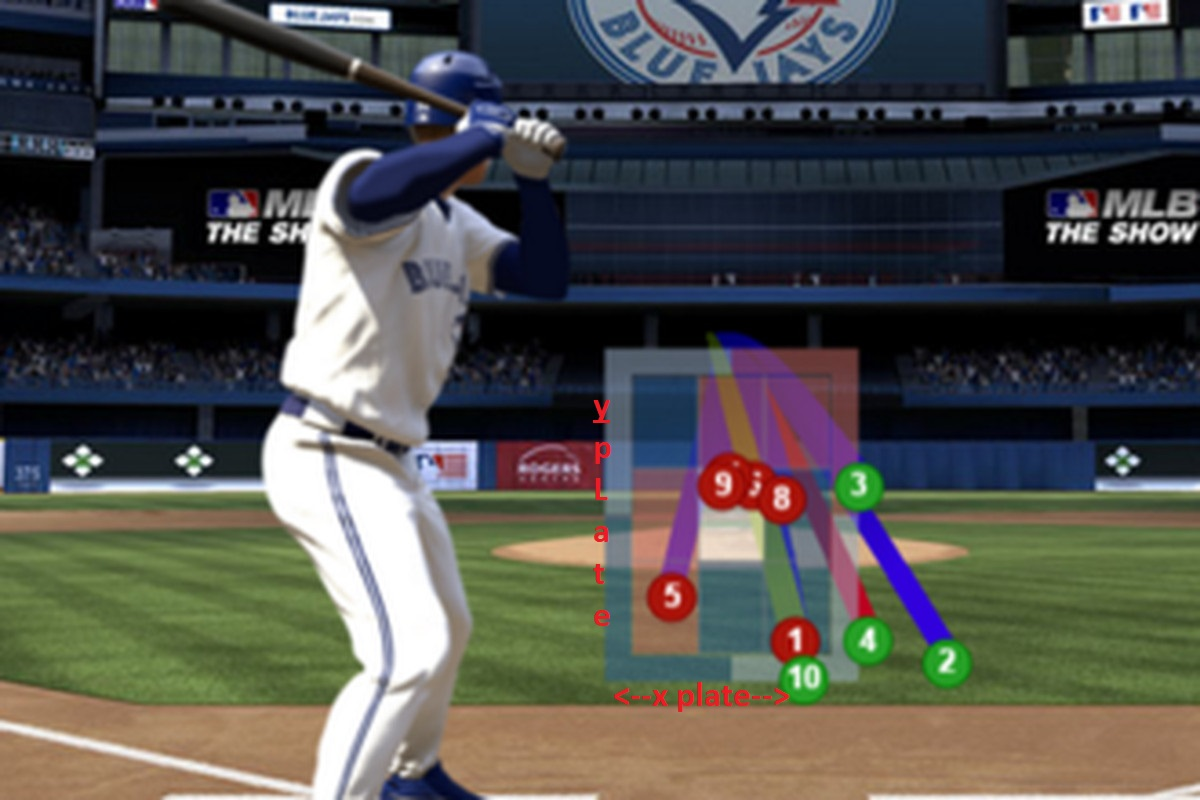

`About the datasoure`: 

pybaseball is a Python package for baseball data analysis. This package scrapes Baseball Reference, Baseball Savant, and FanGraphs so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods.

github link: [pybaseball](https://github.com/jldbc/pybaseball)

`Project Goal:`

1. Create a Support Vector Machine model that will predict the game outcome if strike or ball based on playing habits.

`Content:`
1. Import and Load Libraries/Dataset
2. Defining Features and Label
3. SVM
4. Model Evaluation
5. Parameter Optimization
6. Optimized SVM
7. Model Test Run

***

# 1. Import and Load Libraries/Dataset

In [2]:
from pybaseball import statcast, playerid_lookup, statcast_pitcher, pitching_stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Let's extract some baseball player informartion

In [5]:
df = statcast_pitcher('2015-01-01', '2016-01-01', 477132)

Gathering Player Data


In [6]:
# show data
print(df.shape)
df.head(1)

(3810, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,SL,2015-10-13,90.4,1.3,6.16,"Kershaw, Clayton",527038,477132,field_out,hit_into_play,NaN,NaN,NaN,NaN,13.0,"Wilmer Flores grounds out, third baseman Justi...",D,R,L,NYM,LAD,X,5.0,ground_ball,2,0,2015,-0.65,0.16,-0.59,1.41,NaN,NaN,493316.0,2,7,Bot,107.98,166.28,NaN,NaN,454560,NaN,151013_221554,-3.607,-131.498,-6.659,-6.603,30.234,-29.101,3.56,1.62,45.0,103.4,1.0,89.7,2402.0,6.3,446254,477132,454560,408236,435062,457759,608369,444843,571771,624577,50.0,0.5,0.468,0.0,1.0,0.0,0.0,4.0,54,3,Slider,1,3,1,3,3,1,1,3,Standard,Strategic,NaN,-0.038,-0.297


# 2. Defining Features and Label

### Determine our label (y)

We’re interested in looking at whether a 'strike' or a 'ball'. That information is stored in the `type` feature. Let's Look at the unique values stored in the `type` feature to get a sense of how balls and strikes are recorded.

In [7]:
df.type.unique()

array(['X', 'B', 'S'], dtype=object)

`Note:` About Strike and Ball

`Strike` 
- Pitcher throw the ball into the strike zone and the batter did'nt swing.
- Pitcher throw the ball and the batter swing but didnt hit the ball. Does'nt matter if the ball is in strike zone or not.
- 3 strike then the batter is out.

`Ball` 
- Pitcher throw the ball outside the strike zone and the batter didnt swing.
- 4 ball then the batter will go on the 1st base.

Reference: [baseball rules video](https://www.youtube.com/watch?v=E160D9rEY0M0)

We know every row’s `type` feature is either an 'S' for a strike, a 'B' for a ball, or an 'X' for neither (for example, an 'X' could be a hit or an out).

We’ll want to use this feature as the label of our data points. However, instead of using strings,   
it will be easier if we change every 'S' to a 1 and every 'B' to a 0. We can change the values of a DataFrame column using the map() functions.

In [8]:
df['type'] = df['type'].map({'S':1, 'B':0})
df.type.unique()

array([nan,  0.,  1.])

We will deal with the Nan value later, first let's check the proportion and balance of our label values.

In [9]:
# count of 1 and 0 in type
# 1 is strike and 0 is ball
print(df['type'].value_counts())

1.0    1969
0.0    1213
Name: type, dtype: int64


There are 1969(around 60%) strikes and 1213(around 40%) balls. This distribution of strike and balls are pretty well balance. 

### Determine our features (X)

We want to predict whether a pitch is a ball or a strike based on its location over the plate. We can find the ball’s location in the columns plate_x and plate_z.

`Note:` 

 - `plate_x:`  Measures how far left or right the pitch is from the center of home plate. If plate_x = 0, that means the pitch was directly in the middle of the home plate.
 - `plate_z:` Measures how high off the ground the pitch was. If plate_z = 0, that means the pitch was at ground level when it got to the home plate 

<br>
For the sake of this project we will focus only building our SVM model though it may be better to do a PCA and other feature selection methods, we will save that task in some other time. 

Let's check and drop null values on our selected columns(plate_x, plate_z, and type). Our SVM won't accept any null values.

In [10]:
# number of null values
df[['plate_x', 'plate_z', 'type']].isna().sum()

plate_x    106
plate_z    106
type       628
dtype: int64

In [11]:
# proportion of null values
df[['plate_x', 'plate_z', 'type']].isna().sum() / len(df)

plate_x    0.027822
plate_z    0.027822
type       0.164829
dtype: float64

In [12]:
# remove every row that has a NaN in any of these columns and save result into a new dataset.
df_new = df.dropna(subset = ['plate_x', 'plate_z', 'type'])

In [13]:
# verify df_new 
# proportion of null values
df_new[['plate_x', 'plate_z', 'type']].isna().sum() / len(df)

plate_x    0.0
plate_z    0.0
type       0.0
dtype: float64

### Visualization

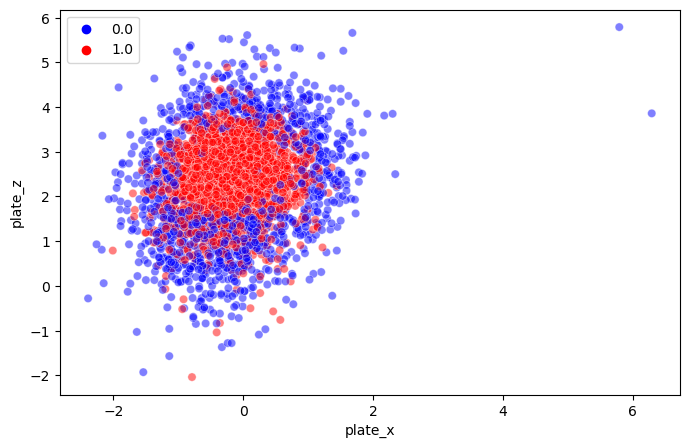

In [20]:
plt.figure(figsize=(8,5))
sns.scatterplot(df['plate_x'], df['plate_z'], hue = df['type'], palette=['blue', 'red'], alpha = 0.5)
plt.legend()

We can see from the graph that the srike zone are mostly on the centers of the radius while balls are within the eadge area.

# 3. SVM

In [15]:
X = df_new[['plate_x', 'plate_z']]
y = df_new['type']

In [16]:
# Split data to training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size = 0.33, random_state = 0)

`NOTE:`
<br/>
We will not perform normalization for this SVM Model, thats because we want the true value of our features to represent the location of the baseball ball in the plate x and z coordinate. Also because plate x and z are on the same unit of measurement so there will be no defference in scaling.

In [17]:
clf_svc = SVC(random_state = 0)
clf_svc.fit(x_train, y_train)

SVC(random_state=0)

<AxesSubplot:xlabel='plate_x', ylabel='plate_z'>

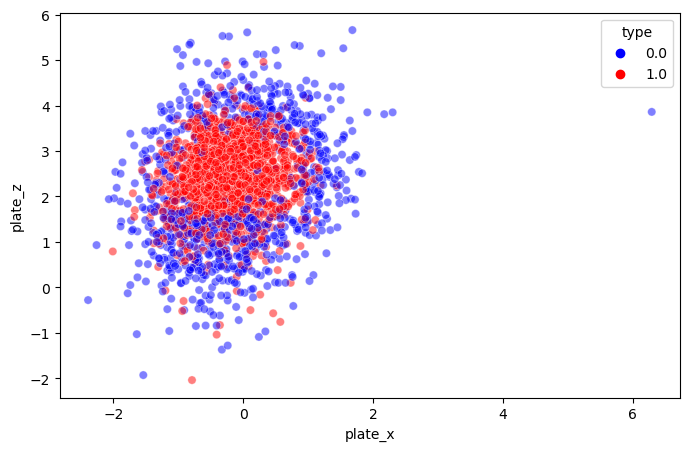

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(x_train.plate_x, x_train.plate_z, hue = df['type'], palette=['blue', 'red'], alpha = 0.5)

# 4. Model Evaluation

In [22]:
# Accuracy score
print(clf_svc.score(x_train, y_train))
print(clf_svc.score(x_test, y_test))

0.8122605363984674
0.7920310981535471


#### Confusion Matrix

In [23]:
# x_test prediction values
y_pred = clf_svc.predict(x_test)

In [24]:
model_matrix = confusion_matrix(y_test, y_pred)
model_matrix

array([[280, 118],
       [ 96, 535]], dtype=int64)

#### Visualize

<AxesSubplot:>

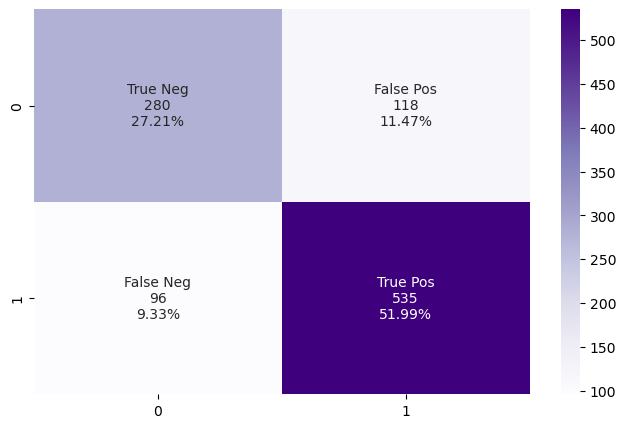

In [25]:
# code
fig, ax = plt.subplots(figsize=(8,5))

# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

# 5. Parameter Optimization
Find the best 'gamma' and 'C' using GridSearvhCV.

In [26]:
grid_params = [{'gamma': ['scale',1, .1, .001, .0001],
               'C':     [0.5, 1, 10, 100] # Value for C must be > 0
              }]

# Note:
# C default value is 1
# gamma default value is 'scale'

In [27]:
gs = GridSearchCV(estimator = clf_svc, 
                  param_grid = grid_params, 
                  scoring = 'accuracy',
                  cv = 5, )

In [28]:
gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid=[{'C': [0.5, 1, 10, 100],
                          'gamma': ['scale', 1, 0.1, 0.001, 0.0001]}],
             scoring='accuracy')

Show best parameter and score

In [29]:
print(gs.best_params_, gs.best_score_)

{'C': 0.5, 'gamma': 'scale'} 0.8141808084632773


# 6. Optimized SVM 

In [31]:
clf_svc = SVC(random_state = 0, C = 0.5, gamma = 'scale')
clf_svc.fit(x_train, y_train)

SVC(C=0.5, random_state=0)

In [32]:
print(clf_svc.score(x_train, y_train))
print(clf_svc.score(x_test, y_test))

0.814176245210728
0.7920310981535471


<AxesSubplot:>

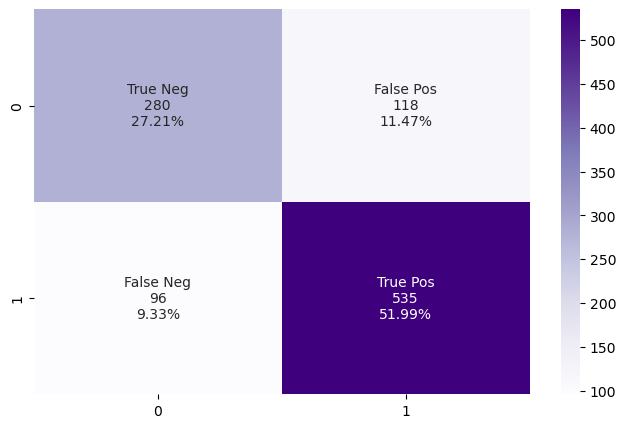

In [33]:
model_matrix = confusion_matrix(y_test, y_pred)
# code
fig, ax = plt.subplots(figsize=(8,5))

# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

Theres no signicant difference in our scores for our tuned and untuned model.

# 7. Model Test Run

We can copy the values in the below data or we can just made up our own. Look at the visualization graph above and think of a coordinate that will result to a strike or a ball.

In [34]:
df_new[['plate_x', 'plate_z', 'type']].head(4)

,plate_x,plate_z,type
1,-0.08,1.02,0.0
2,-0.32,1.41,0.0
5,0.28,2.02,1.0
7,0.52,2.31,1.0


In [35]:
# from index1
Player1 = [[-0.08, 1.02]]

# this cordinate will surely hit s strike!
Player2 = [[0,2.5]]

In [36]:
print(clf_svc.predict(Player1))
print(clf_svc.predict(Player2))

[0.]
[1.]


-fin